In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import pandas as pd
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt


In [6]:
# Read in CSV

o_data = pd.read_csv('sensors_data_Vessel1_20230508.csv')

o_data.head(5)

,draft,speedOverGround,courseOverGround,windSpeed,windDirection,windWavesSignificantHeight,windWavesZeroCrossingPeriod,windWavesDirection,swellSignificantHeight,swellZeroCrossingPeriod,swellDirection,currentSpeed,currentDirection,waterDepth,fuelMassFlow
0,5.901807,5.157308,211.389999,8.044598,250.359271,0.604218,3.052564,245.339647,0.125000,3.879783,241.248730,0.060868,149.966453,13.59750,0.202109
1,5.887334,5.129390,212.743903,8.069089,250.154624,0.609470,3.052958,245.380179,0.123610,3.902562,239.113185,0.061043,153.253748,13.25122,0.202227
2,5.886533,5.134158,212.157501,8.097059,249.965965,0.617564,3.053715,245.520500,0.121978,3.925689,236.333132,0.061794,157.068520,13.00750,0.201974
3,5.884516,5.129014,211.647500,8.129371,249.795188,0.623060,3.053963,245.595967,0.122784,3.925000,234.743811,0.061222,159.910039,12.78250,0.203896
4,5.887981,5.153450,211.572500,8.166148,249.639649,0.624373,3.057707,245.615459,0.125479,3.914312,233.971958,0.060738,161.038265,12.73000,0.203379


In [7]:
# check the statistics. It is not necessary
o_data.describe()

,draft,speedOverGround,courseOverGround,windSpeed,windDirection,windWavesSignificantHeight,windWavesZeroCrossingPeriod,windWavesDirection,swellSignificantHeight,swellZeroCrossingPeriod,swellDirection,currentSpeed,currentDirection,waterDepth,fuelMassFlow
count,41025.000000,41025.000000,41025.000000,41025.000000,41025.000000,41025.000000,41025.000000,41025.000000,41025.000000,41025.000000,41025.000000,41025.000000,41025.000000,41025.000000,41025.000000
mean,6.020380,7.369780,138.233535,7.111252,204.032677,0.541836,2.509293,203.681837,0.183754,3.311611,171.771946,0.089168,170.427415,17.828402,0.502078
std,0.554666,1.907991,96.441083,3.393846,84.483235,0.496363,1.177409,84.268877,0.138122,1.203116,96.209145,0.072560,101.022166,7.537917,0.227583
min,3.052449,0.000000,0.008330,0.051508,0.017409,0.000000,0.000000,0.002858,0.000000,0.000000,0.000000,0.000218,0.035442,4.050000,0.000000
25%,5.753898,6.892273,37.260206,4.501013,143.790268,0.166885,1.787614,143.861548,0.093139,2.543889,72.520794,0.038362,73.881822,13.137500,0.365111
50%,5.994312,7.571340,185.534328,6.818493,219.793354,0.442754,2.571628,220.830102,0.147583,3.290000,195.100351,0.070211,166.135213,16.905000,0.469684
75%,6.208308,8.658104,216.117496,9.362980,268.150664,0.809500,3.326778,265.641971,0.243111,4.044972,246.766076,0.118163,256.389211,21.512820,0.747067
max,9.697656,10.172814,359.897932,22.220428,359.979302,4.910757,7.615618,360.000000,1.292560,9.593130,360.000000,0.637598,359.995485,93.615383,1.021509


In [8]:
# original dataset contains fuelmassflow < 0. This is not a must if there is no invalid values

print(o_data.shape)
df = o_data.drop(o_data[o_data['fuelMassFlow'] < 0].index)

df.shape

(41025, 15)


(41025, 15)

In [9]:
# Here no hyperparameters have been tuned. Thus only training + validation, no testing 
# Later if hyperparameters have to be tuned, divide into train, val and test

train_df=df.sample(frac=0.8,random_state=20) #random state is a seed value
val_df=df.drop(train_df.index)
print(train_df.shape)
print(val_df.shape)

(32820, 15)
(8205, 15)


In [11]:
# For this part, making sure that FuelMassFlow is stored in the 15th column in the csv. 
# Otherwise change the number '14' and ':14' accordingly
class dds(Dataset):
    def __init__(self, df):
        x = df.iloc[:, :14].values
        y = df.iloc[:, 14].values    

        self.x_tensor = torch.tensor(x, dtype = torch.float32)
        self.y_tensor = torch.tensor(y, dtype = torch.float32).reshape(-1,1)

    def __len__(self):
        return len(self.y_tensor)

    def __getitem__(self,idx):
        return self.x_tensor[idx], self.y_tensor[idx]

In [12]:
#--- hyperparameters ---
# all hyperparameters are tunable when needed
N_EPOCHS = 200    
LEARNING_RATE = 0.005
BATCH_SIZE = 64
REPORT_EVERY = 1
input_n = 14
output_n = 1
HIDDEN_SIZE = 10

In [13]:
train_ds = dds(train_df)
val_ds = dds(val_df)

train_loader = DataLoader(dataset = train_ds, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(dataset = val_ds, batch_size = val_df.shape[0], shuffle = False)


In [14]:
# architecture:
class fnn(torch.nn.Module):
    def __init__(self, input_dim, out_dim, hidden_size):
        super(fnn, self).__init__()
        self.inputs = input_dim
        self.outputs = out_dim
        self.hidden = hidden_size
        
        # layers
        self.fc1 = torch.nn.Linear(self.inputs, hidden_size)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc4 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc5 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc6 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc7 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc8 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc9 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc10 = torch.nn.Linear(hidden_size, self.outputs)
        self.bn = torch.nn.BatchNorm1d(hidden_size)

        
        # activation
        self.lrelu = torch.nn.LeakyReLU(0.2)
        self.relu = torch.nn.ReLU()
        self.tanh = torch.nn.Tanh()
        self.elu = torch.nn.ELU()
        self.sigmoid= torch.nn.Sigmoid()
        self.logsigmoid= torch.nn.LogSigmoid()
        
        # initialize the weights
        self.init_weights()
        
    def init_weights(self):
        torch.nn.init.kaiming_normal_(self.fc1.weight)
        torch.nn.init.kaiming_normal_(self.fc2.weight)
        torch.nn.init.kaiming_normal_(self.fc3.weight)
        torch.nn.init.kaiming_normal_(self.fc4.weight)
        torch.nn.init.kaiming_normal_(self.fc5.weight)
        torch.nn.init.kaiming_normal_(self.fc6.weight)
        torch.nn.init.kaiming_normal_(self.fc7.weight)
        torch.nn.init.kaiming_normal_(self.fc8.weight)
        torch.nn.init.kaiming_normal_(self.fc9.weight)
        torch.nn.init.kaiming_normal_(self.fc10.weight)


        
    def forward(self, features):
        output = self.fc1(features)
        output = self.lrelu(output)  
        output = self.fc2(output)
        output = self.lrelu(output)
        output = self.fc3(output)
        output = self.lrelu(output)
        output = self.fc4(output)
        output = self.lrelu(output)
        output = self.fc5(output)
        output = self.lrelu(output)       
        output = self.fc6(output)
        output = self.lrelu(output)
        output = self.fc7(output)
        output = self.lrelu(output)
        output = self.fc8(output)
        output = self.lrelu(output)
        output = self.fc9(output)

        output = self.lrelu(output)
        output = self.fc10(output)
        return output


In [15]:
model = fnn(input_dim = input_n, out_dim = output_n, hidden_size = HIDDEN_SIZE)

In [16]:
model

fnn(
  (fc1): Linear(in_features=14, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=10, bias=True)
  (fc5): Linear(in_features=10, out_features=10, bias=True)
  (fc6): Linear(in_features=10, out_features=10, bias=True)
  (fc7): Linear(in_features=10, out_features=10, bias=True)
  (fc8): Linear(in_features=10, out_features=10, bias=True)
  (fc9): Linear(in_features=10, out_features=10, bias=True)
  (fc10): Linear(in_features=10, out_features=1, bias=True)
  (bn): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lrelu): LeakyReLU(negative_slope=0.2)
  (relu): ReLU()
  (tanh): Tanh()
  (elu): ELU(alpha=1.0)
  (sigmoid): Sigmoid()
  (logsigmoid): LogSigmoid()
)

In [17]:
criterion = torch.nn.MSELoss()
#criterion = torch.nn.L1Loss()

In [18]:
optimizer = torch.optim.Adam(params = model.parameters(), lr=LEARNING_RATE)
#optimizer = torch.optim.SGD(params = model.parameters(), lr=LEARNING_RATE, momentum = 0.9)

In [28]:
valid_list = [0]
patience = 0
val_points = np.zeros((val_df.shape[0],2,N_EPOCHS//REPORT_EVERY))
train_sample_points = np.zeros((1000,2,N_EPOCHS//REPORT_EVERY))
loss_train_val = np.zeros((N_EPOCHS//REPORT_EVERY,2))
for epoch in range(N_EPOCHS):
    
    loss_epoch_train = 0
    for features, targets in train_loader:
        # forward propagation
        output = model.forward(features)
        loss = criterion(output, targets)
        #initialize the gradient to zero
        optimizer.zero_grad()
        #back propagation
        loss.backward()
        #update the weights
        optimizer.step()
        
        loss_epoch_train+= targets.shape[0]*loss.item()
    model.eval() # stop training:

    # predict validation set:
    for feature_val, target_val in val_loader:
        prediction_val = model.forward(feature_val)
        mse_val = criterion(prediction_val, target_val)
   
    # early stop can be added
    # If needed, record the model with the best accuracy

    
    if (epoch+1)%REPORT_EVERY == 0:   
       
        mse_epoch_train = loss_epoch_train/train_df.shape[0]
        print('Epoch {}/{}:'.format(epoch+1, N_EPOCHS))
        print('loss_train: {:4f}'.format(mse_epoch_train))
        print('loss_valid: {:4f}'.format(mse_val.item()))
        val_points[:, 0, (epoch+1)//REPORT_EVERY-1] = target_val[:,0].detach().numpy()
        val_points[:, 1, (epoch+1)//REPORT_EVERY-1] = prediction_val[:,0].detach().numpy()
        loss_train_val[int((epoch+1)/REPORT_EVERY)-1, 0] = np.round(mse_epoch_train, 4)
        loss_train_val[int((epoch+1)/REPORT_EVERY)-1, 1] = np.round(mse_val.item(), 4)
    model.train()

    

Epoch 1/200:
loss_train: 4.596992
loss_valid: 0.112613
Epoch 2/200:
loss_train: 0.089663
loss_valid: 0.074678
Epoch 3/200:
loss_train: 0.067976
loss_valid: 0.062362
Epoch 4/200:
loss_train: 0.059047
loss_valid: 0.056053
Epoch 5/200:
loss_train: 0.054914
loss_valid: 0.053562
Epoch 6/200:
loss_train: 0.052697
loss_valid: 0.056436
Epoch 7/200:
loss_train: 0.051818
loss_valid: 0.050712
Epoch 8/200:
loss_train: 0.050628
loss_valid: 0.054374
Epoch 9/200:
loss_train: 0.051047
loss_valid: 0.049442
Epoch 10/200:
loss_train: 0.049747
loss_valid: 0.049146
Epoch 11/200:
loss_train: 0.048465
loss_valid: 0.050897
Epoch 12/200:
loss_train: 0.047168
loss_valid: 0.046778
Epoch 13/200:
loss_train: 0.045870
loss_valid: 0.047152
Epoch 14/200:
loss_train: 0.043153
loss_valid: 0.042693
Epoch 15/200:
loss_train: 0.038352
loss_valid: 0.036591
Epoch 16/200:
loss_train: 0.028538
loss_valid: 0.030551
Epoch 17/200:
loss_train: 0.021386
loss_valid: 0.016763
Epoch 18/200:
loss_train: 0.016542
loss_valid: 0.016511
E

Epoch 147/200:
loss_train: 0.003691
loss_valid: 0.003184
Epoch 148/200:
loss_train: 0.003633
loss_valid: 0.003026
Epoch 149/200:
loss_train: 0.003759
loss_valid: 0.003230
Epoch 150/200:
loss_train: 0.003669
loss_valid: 0.003085
Epoch 151/200:
loss_train: 0.003663
loss_valid: 0.003188
Epoch 152/200:
loss_train: 0.003885
loss_valid: 0.003426
Epoch 153/200:
loss_train: 0.003573
loss_valid: 0.002895
Epoch 154/200:
loss_train: 0.003801
loss_valid: 0.002870
Epoch 155/200:
loss_train: 0.003777
loss_valid: 0.003198
Epoch 156/200:
loss_train: 0.003629
loss_valid: 0.003165
Epoch 157/200:
loss_train: 0.003593
loss_valid: 0.004710
Epoch 158/200:
loss_train: 0.003729
loss_valid: 0.003070
Epoch 159/200:
loss_train: 0.003591
loss_valid: 0.003087
Epoch 160/200:
loss_train: 0.003653
loss_valid: 0.003110
Epoch 161/200:
loss_train: 0.003550
loss_valid: 0.003401
Epoch 162/200:
loss_train: 0.003853
loss_valid: 0.003072
Epoch 163/200:
loss_train: 0.003657
loss_valid: 0.003313
Epoch 164/200:
loss_train: 0.00

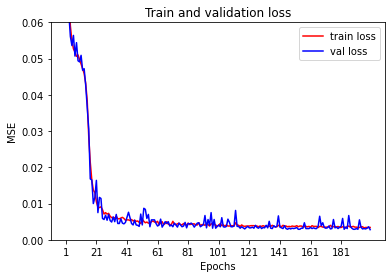

In [30]:
e = np.arange(1, N_EPOCHS+1, REPORT_EVERY, dtype = int)
plt.plot(e, loss_train_val[:,0], c = 'r', label = 'train loss')
plt.plot(e, loss_train_val[:,1], c = 'b', label = 'val loss')
plt.xticks(np.arange(min(e), max(e)+1, 20))
plt.ylim(0, 0.06)
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.title('Train and validation loss')
plt.show()

In [31]:
# save as pre-trained model
state = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
torch.save(state, 'pre_trained_save.pt')